<a href="https://colab.research.google.com/github/alivahidi75/GANS/blob/main/TripleGAN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics         import accuracy_score

import tensorflow as tf
import keras as ks
from keras import layers as lys
from keras import models as mls
from keras import initializers
from keras.utils import to_categorical as ct
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
import io
import gdown
import scipy.io

In [ ]:
class TripleGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, classifier, latent_dim):
        super(TripleGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.classifier = classifier
        self.latent_dim = latent_dim

    def compile(self, g_optimizer, d_optimizer, c_optimizer, g_loss_fn, d_loss_fn, c_loss_fn):
        super(TripleGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.c_optimizer = c_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.c_loss_fn = c_loss_fn

    def train_step(self, sup_images, labels, unsup_images):
        #real_images, real_labels = data  # Assuming data is a tuple of (images, labels)
        real_images = tf.concat([sup_images, unsup_images], axis=0)
        batch_size = tf.shape(real_images)[0]

        # Generate fake images
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Labels for real and fake images
        real_labels_disc = tf.ones((batch_size, 1))
        fake_labels_disc = tf.zeros((batch_size, 1))

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_predictions = self.discriminator(real_images)
            fake_predictions = self.discriminator(generated_images)
            d_loss = self.d_loss_fn(real_labels_disc, real_predictions) + self.d_loss_fn(fake_labels_disc, fake_predictions)

        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_weights))

        # Train the generator
        with tf.GradientTape() as g_tape:
            generated_images = self.generator(random_latent_vectors)
            fake_predictions = self.discriminator(generated_images)
            g_loss = self.g_loss_fn(real_labels_disc, fake_predictions)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_weights))

        # Train the classifier
        with tf.GradientTape() as c_tape:
            # Classify real labeled data
            real_classifications = self.classifier(sup_images)
            c_loss = self.c_loss_fn(labels, real_classifications)

        c_gradients = c_tape.gradient(c_loss, self.classifier.trainable_weights)
        self.c_optimizer.apply_gradients(zip(c_gradients, self.classifier.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss, "c_loss": c_loss}

    def fit(self, labeled_dataset, unlabeled_dataset, epochs, callbacks=None):
      combined_dataset = tf.data.Dataset.zip((labeled_dataset, unlabeled_dataset))
      for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Iterate over the combined dataset
        for step, ((sup_images, labels), unsup_images) in enumerate(combined_dataset):
            # Perform a single training step
            losses = self.train_step(sup_images, labels, unsup_images)

            # Log losses
            if step % 100 == 0:
                print(f"Step {step}: d_loss={losses['d_loss']:.4f}, g_loss={losses['g_loss']:.4f}, c_loss={losses['c_loss']:.4f}")

        # Run callbacks at the end of each epoch
        if callbacks:
            for callback in callbacks:
                callback.on_epoch_end(epoch, logs=losses)


In [ ]:
latent_dim = 7

dr = ks.Sequential(name="Discriminator")
dr.add(lys.Input(shape=(latent_dim,)))
dr.add(lys.Dense(units=180, activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
dr.add(lys.LeakyReLU(alpha=0.4))
dr.add(lys.Dense(units=140, activation='sigmoid',  kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
dr.add(lys.LeakyReLU(alpha=0.4))
dr.add(lys.Dense(units=120, activation='sigmoid',  kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
dr.add(lys.LeakyReLU(alpha=0.4))
dr.add(lys.Dropout(0.4))
dr.add(lys.Dense(1))
dr.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                     │ (None, 180)                 │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 180)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 140)                 │          25,340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 120)                 │          16,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,821 (171.18 KB)

 Trainable params: 43,821 (171.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gr = ks.Sequential(name = "Generator")
gr.add(lys.Input(shape=(latent_dim,)))
gr.add(lys.Dense(180, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
gr.add(lys.Dense(100, activation='tanh',kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_initializer=initializers.Zeros()))
gr.add(lys.Dense(7, activation='relu'))
gr.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 180)                 │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 100)                 │          18,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 7)                   │             707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,247 (79.09 KB)

 Trainable params: 20,247 (79.09 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cr = ks.Sequential(name = "Classifier")
cr.add(lys.Input(shape = (7,)))
cr.add(lys.Dense(256, activation = 'relu'))
cr.add(lys.Dense(128, activation = 'relu'))
cr.add(lys.Dense(10, activation = 'softmax'))
cr.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                     │ (None, 256)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,234 (141.54 KB)

 Trainable params: 36,234 (141.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
file_id = "1Z_mEDB60-BnoKCEbiYqxKchk4NSgLcKW"
output_name = "downloaded_file.xlsx"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_name, quiet=False)
data = pd.read_excel(output_name)
data = data.to_numpy()

Downloading...
From: https://drive.google.com/uc?id=1Z_mEDB60-BnoKCEbiYqxKchk4NSgLcKW
To: /content/downloaded_file.xlsx
100%|██████████| 396k/396k [00:00<00:00, 65.1MB/s]


In [ ]:
'''
input = data[:, 1:8]
output = data[:, 0]
output = output - 1

f = input.shape[1]
pca = PCA(n_components=7)
pca.fit(input)
input= pca.transform(input)
minmax = MinMaxScaler()
dataset =  minmax.fit_transform(input).astype(np.float32)
#dataset = normalizeData(input).astype(np.float32)  # Convert to float32
dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(512)
'''

'\ninput = data[:, 1:8]\noutput = data[:, 0]\noutput = output - 1\n\nf = input.shape[1]\npca = PCA(n_components=7)\npca.fit(input)\ninput= pca.transform(input)\nminmax = MinMaxScaler()\ndataset =  minmax.fit_transform(input).astype(np.float32)\n#dataset = normalizeData(input).astype(np.float32)  # Convert to float32\ndataset = tf.data.Dataset.from_tensor_slices(dataset).batch(512)\n'

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


input = data[:, 1:8]
output = data[:, 0]
output = output - 1

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.1, random_state=42)

X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)


pca = PCA(n_components=7)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_labeled_pca = pca.transform(X_labeled)
X_unlabeled_pca = pca.transform(X_unlabeled)

minmax = MinMaxScaler()
minmax.fit(X_train_pca)

X_train_scaled = minmax.transform(X_train_pca).astype(np.float32)
X_test_scaled = minmax.transform(X_test_pca).astype(np.float32)
X_labeled_scaled = minmax.transform(X_labeled_pca).astype(np.float32)
X_unlabeled_scaled = minmax.transform(X_unlabeled_pca).astype(np.float32)


num_classes = len(np.unique(y_labeled))
y_labeled_onehot = tf.keras.utils.to_categorical(y_labeled, num_classes=num_classes)
labels = y_labeled_onehot

batch_size = 512


labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled_scaled, y_labeled_onehot))
labeled_dataset = labeled_dataset.shuffle(buffer_size=len(X_labeled_scaled)).batch(batch_size)


unlabeled_dataset = tf.data.Dataset.from_tensor_slices(X_unlabeled_scaled)
unlabeled_dataset = unlabeled_dataset.shuffle(buffer_size=len(X_unlabeled_scaled)).batch(batch_size)

num_classes = len(np.unique(y_test))
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_onehot))
test_dataset = test_dataset.batch(batch_size)

In [ ]:
triple_gan = TripleGAN(gr, dr, cr, latent_dim)
triple_gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(learning_rate= ks.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=10000,decay_rate=0.5),beta_1=0.5),
    d_optimizer=tf.keras.optimizers.Adam(learning_rate= ks.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=10000,decay_rate=0.5),beta_1=0.5),
    c_optimizer=tf.keras.optimizers.Adam(learning_rate= ks.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=10000,decay_rate=0.5),beta_1=0.5),
    g_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    c_loss_fn=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
history = triple_gan.fit(labeled_dataset, unlabeled_dataset, epochs=2000)

Epoch 1/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2987
Epoch 2/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2969
Epoch 3/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2952
Epoch 4/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2935
Epoch 5/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2919
Epoch 6/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2902
Epoch 7/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2886
Epoch 8/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2870
Epoch 9/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2854
Epoch 10/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2839
Epoch 11/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2823
Epoch 12/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2807
Epoch 13/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2791
Epoch 14/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_loss=2.2774
Epoch 15/2000
Step 0: d_loss=16.1181, g_loss=16.1181, c_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8771 - loss: 0.3307
Test Loss: 0.3307, Test Accuracy: 0.8771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


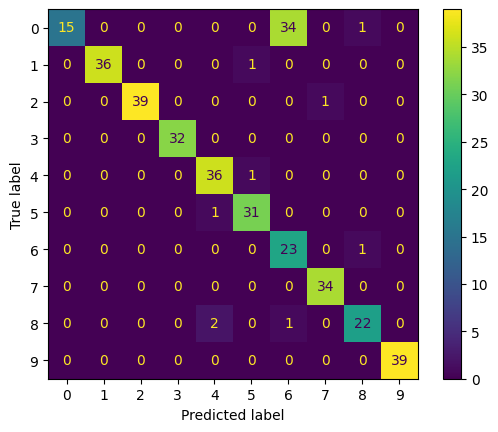

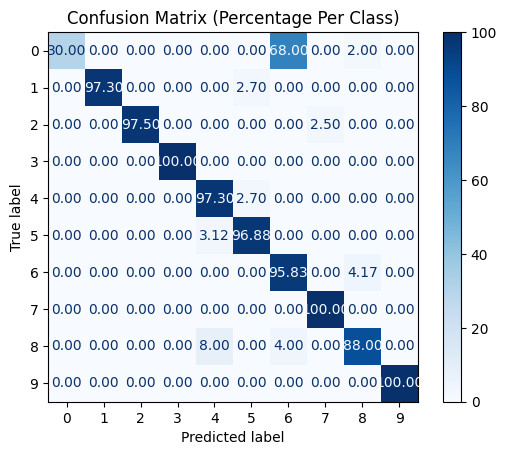

Accuracy Test:  87.71428571428571


In [ ]:

# Evaluate the classifier on the test dataset
test_loss, test_accuracy = cr.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_pred_probs = cr.predict(test_dataset)
# Convert predicted probabilities to class labels
y_pred_labels = tf.argmax(y_pred_probs, axis=1).numpy()
y_true_labels = tf.concat([y for _, y in test_dataset], axis=0).numpy()

# If the labels are one-hot encoded, convert them to integers
if y_true_labels.ndim > 1:
    y_true_labels = tf.argmax(y_true_labels, axis=1).numpy()

# Compute the confusion matrix

confusion_matrix = metrics.confusion_matrix(y_true_labels,y_pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
cm_display.plot()
pt.show()

confusion_matrix_per_class = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1, keepdims=True) * 100
cm_display_per_class = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_per_class,display_labels=[0,1,2,3,4,5,6,7,8,9])
cm_display_per_class.plot(cmap="Blues", values_format=".2f")
pt.title("Confusion Matrix (Percentage Per Class)")
pt.show()

acc_test=accuracy_score(y_true_labels,y_pred_labels)
print("Accuracy Test: ", acc_test*100)



Dataset

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


input = data[:, 1:8]
output = data[:, 0]
output = output - 1

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.1, random_state=42)

X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)


pca = PCA(n_components=7)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_labeled_pca = pca.transform(X_labeled)
X_unlabeled_pca = pca.transform(X_unlabeled)

minmax = MinMaxScaler()
minmax.fit(X_train_pca)

X_train_scaled = minmax.transform(X_train_pca).astype(np.float32)
X_test_scaled = minmax.transform(X_test_pca).astype(np.float32)
X_labeled_scaled = minmax.transform(X_labeled_pca).astype(np.float32)
X_unlabeled_scaled = minmax.transform(X_unlabeled_pca).astype(np.float32)


num_classes = len(np.unique(y_labeled))
y_labeled_onehot = tf.keras.utils.to_categorical(y_labeled, num_classes=num_classes)
labels = y_labeled_onehot

batch_size = 512


labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled_scaled, y_labeled_onehot))
labeled_dataset = labeled_dataset.shuffle(buffer_size=len(X_labeled_scaled)).batch(batch_size)


unlabeled_dataset = tf.data.Dataset.from_tensor_slices(X_unlabeled_scaled)
unlabeled_dataset = unlabeled_dataset.shuffle(buffer_size=len(X_unlabeled_scaled)).batch(batch_size)

num_classes = len(np.unique(y_test))
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_onehot))
test_dataset = test_dataset.batch(batch_size)